In [10]:
%reload_ext autoreload
%autoreload 2

import pandas, numpy, sklearn
from local_surrogate_analysis import *
from synthetic_datasets import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'plt', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


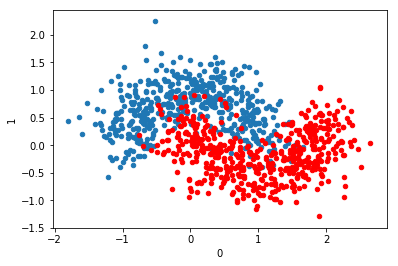

In [12]:
## Get dataset

X, y = get_moons(n_samples=1000, random_state=4)

ylabels = ['Class 0', 'Class 1']
feature_names = ['feature 0', 'feature 1']

fig, ax = subplots(1)
X[y==0].plot(kind='scatter', x=0, y=1, ax=ax)
X[y==1].plot(kind='scatter', x=0, y=1, ax=ax, c='r')

In [13]:
## Train a back-box classifier on the synthetic dataset
import sklearn.model_selection, sklearn.ensemble

train, test, labels_train, labels_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20)

clf = sklearn.ensemble.RandomForestClassifier(n_estimators=200)
clf.fit(train, labels_train)
print(sklearn.metrics.accuracy_score(labels_test, clf.predict(test)))
print(sklearn.metrics.classification_report(labels_test, clf.predict(test)))

0.945
             precision    recall  f1-score   support

          0       0.94      0.95      0.95       105
          1       0.95      0.94      0.94        95

avg / total       0.95      0.94      0.94       200



Points inside the circle
- Frontiers around, in every direction, with ~ the same weight


[('feature 1', -0.34208014210325155), ('feature 0', 0.10166707379058328)]
Predicted class (clf): [0]
Predicted probability (LIME reg) to be in the above class (clf) [ 0.60118955]
LIME (genre de) R2: 0.419817831498


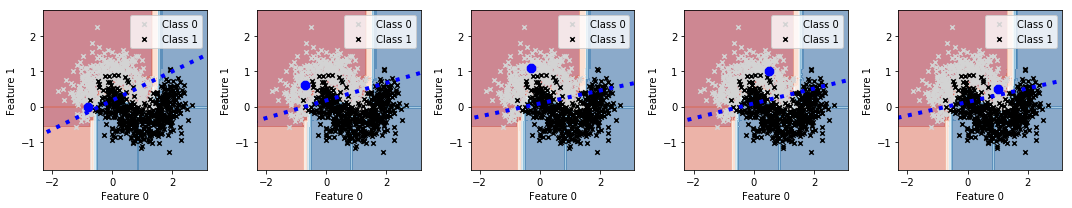

In [5]:
xs_toexplain = [pandas.Series([-0.8,0]), pandas.Series([-0.7,0.6]), pandas.Series([-0.3,1.1]), pandas.Series([0.5,1]), pandas.Series([1, 0.5])]
labels_toexplain = np.zeros(len(xs_toexplain))
LIME_graph(X, y, feature_names, ylabels, clf, xs_toexplain, labels_toexplain, verbose=True, subplots=True)
tight_layout()
savefig('./illustrations/LIME-moon-1.pdf')

[('feature 0', 0.30938650684644137), ('feature 1', -0.23547376337153272)]
Predicted class (clf): [1]
Predicted probability (LIME reg) to be in the above class (clf) [ 0.76711636]
LIME (genre de) R2: 0.459808176155


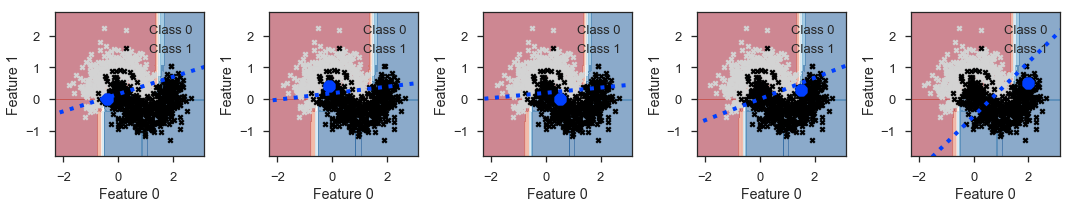

In [262]:
xs_toexplain = [pandas.Series([-0.4,0]), pandas.Series([-0.1,0.4]), pandas.Series([0.5,0]), pandas.Series([1.5, 0.3]), pandas.Series([2, 0.5])]
labels_toexplain = [0 for _ in range(len(xs_toexplain))]
LIME_graph(X, y, feature_names, ylabels, clf, xs_toexplain, labels_toexplain, verbose=True, subplots=True)
tight_layout()
savefig('./illustrations/LIME-moon-2.pdf')

[('feature 1', -0.28815039125194175), ('feature 0', 0.16351645848970708)]
Predicted class (clf): [1]
Predicted probability (LIME reg) to be in the above class (clf) [ 0.83866023]
LIME (genre de) R2: 0.39060289151


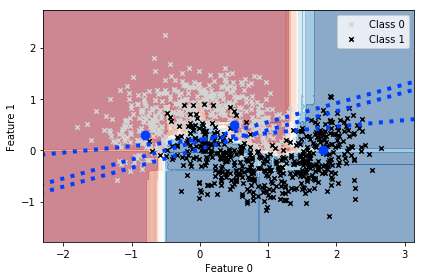

In [15]:
'''
WHI illustration 1
'''
xs_toexplain = [pandas.Series([-0.8,0.3]), pandas.Series([0.5,0.5]), pandas.Series([1.8, 0.0])]
#xs_toexplain = [pandas.Series([-0.5,0.5]), pandas.Series([0.5,0.5]), pandas.Series([1.8, -0.0])]
labels_toexplain = [0 for _ in range(len(xs_toexplain))]
LIME_graph(X, y, feature_names, ylabels, clf, xs_toexplain, labels_toexplain, verbose=True, subplots=False)

tight_layout()
savefig('./illustrations/whi_examples_lime2.pdf')

In [21]:
'''
WHI illustration 2
'''


'''
Idem avec petit kernel width au lieu de sampling restreint
'''
import lime_assessment
import lime_assessment.lime_tabular
from sklearn.metrics import euclidean_distances, accuracy_score, roc_auc_score, r2_score
from collections import defaultdict
from shap import KernelExplainer

def accuracy(model_lime_pred, dataset, pred_fn, measure, label_toexplain):
    y_clf = pred_fn(dataset)[:,label_toexplain]
    y_pred_lime = model_lime_pred(dataset)
    return measure(y_clf, y_pred_lime) 

def lime_pred(obs, exp, label_toexplain, dataset_ref, regression): #entrée observation, sortie pred
    dataset_ref = (dataset_ref-exp.mean_)/exp.scale_
    surrogate = exp.easy_model[label_toexplain]
    y_m_surrogate_pred_proba =  surrogate.predict(obs.iloc[:,exp.used_features[label_toexplain]])
    if regression:
        return y_m_surrogate_pred_proba
    else:
        # OK for a binary classification problem
        y_m_surrogate_pred = numpy.zeros(obs.shape[0])
        mask = y_m_surrogate_pred_proba<0.5
        y_m_surrogate_pred[mask] = 1-label_toexplain
        mask = y_m_surrogate_pred_proba>=0.5
        y_m_surrogate_pred[mask] = label_toexplain
        return y_m_surrogate_pred

def lime_local_results(x_toexplain, dataset_train_lime, dataset_accuracy, pred_fn, label_toexplain, kernel_width=None):
    #entrée observation, dataset train lime, dataset accuracy, retour accuracy
    explainer = lime_assessment.lime_tabular.LimeTabularExplainer(dataset_train_lime, 
                                                                  discretize_continuous=False, kernel_width=kernel_width)
    exp = explainer.explain_instance(x_toexplain,
                                     pred_fn,
                                     num_features=2,
                                     top_labels=len(ylabels), 
                                     labels=range(len(ylabels)))
    regression = True
    model_lime_pred = lambda obs: lime_pred(obs, exp, label_toexplain, dataset_train_lime, regression=regression)
    if regression == False:
        pred_function = lambda obs: pred_fn(obs)>=0.5
        measure = accuracy_score
    else:
        pred_function = lambda obs: pred_fn(obs)>=0.5
        measure = roc_auc_score#r2_score
    acc = accuracy(model_lime_pred, dataset_accuracy, pred_function, measure, label_toexplain)
    
    '''
    ici on va sortir stab = stability()
    '''
    return acc

def get_random_points_within_hypersphere(x_toexplain, r=1, N=100):
    # Generate N random points in a hypersphere of radius r
    res = []
    N_todraw = N
    while len(res) < N:
        N_todraw = N - len(res)
        X_generated = numpy.random.uniform(low=[x_toexplain-r for _ in range(N_todraw)], high=[x_toexplain+r for _ in range(N_todraw)])
        dists = euclidean_distances(x_toexplain.to_frame().T, X_generated)[0]
        for i in range(X_generated.shape[0]):
            if dists[i] < r:
                res.append(pandas.Series(X_generated[i], x_toexplain.index))
    X_generated = pandas.DataFrame(res)
    return X_generated

0   -0.8
1    0.3
dtype: float64
0
1
2
3
4
5
6
7
8
9
0    0.5
1    0.5
dtype: float64
0
1
2
3
4
5
6
7
8
9
0    1.8
1    0.0
dtype: float64
0
1
2
3
4
5
6
7
8
9
3
{0.10000000000000001: array([ 0.87374749]), 0.20000000000000001: array([ 0.90956077]), 0.29999999999999999: array([ 0.91608453]), 0.40000000000000002: array([ 0.93940186]), 0.5: array([ 0.94657092]), 0.59999999999999998: array([ 0.9298296]), 0.69999999999999996: array([ 0.93279359]), 0.80000000000000004: array([ 0.95046782]), 0.90000000000000002: array([ 0.94229336]), 1.0: array([ 0.91826482])}


/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


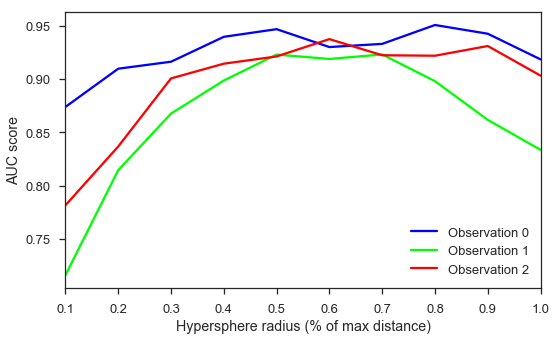

In [27]:
sns.set_style('ticks')
sns.set_context("talk")


#fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
colors= ['blue', 'lime', 'red']
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
for i in range(len(xs_toexplain)):
    x_toexplain = xs_toexplain[i]
    dict_acc_for_obs = obs_list[i]
    df_acc = pandas.DataFrame.from_dict(dict_acc_for_obs, orient='index')
    
    sns.tsplot(data=np.array(df_acc).T, err_style="ci_bars", condition="Observation %i"%i, time=df_acc.index, color=colors[i])

plt.xlabel('Hypersphere radius (% of max distance)')
plt.ylabel('AUC score')
tight_layout()
savefig('./illustrations/whi_radius_lime2.pdf')


In [33]:
'''
Heatmap de AccGain
'''

dataset = X
DISTS_ALL = euclidean_distances(dataset)


import ugs_new_cap as gs
from sklearn.metrics import pairwise_distances
from sklearn import linear_model

def generate_inside_ball(center, segment=(0,1), n=1):
    def norm(v):
        return np.linalg.norm(v, ord=2, axis=1)
    d = center.shape[1]
    z = np.random.normal(0, 1, (n, d))
    z = np.array([a * b / c for a, b, c in zip(z, np.random.uniform(*segment, n),  norm(z))])
    z = z + center
    return z # les z sont a distance de center comprise dans le segment 
#boucle sur tout test dataset
#res_acc_gain = defaultdict(float)
#missing = defaultdict(int)
ite = 0
RADIUS_TRAIN_LOCAL = 1.0
RADIUS_ACC = 0.3
avg_lime_acc = []

missing = 0
x_idxes = []


radius_train = RADIUS_TRAIN_LOCAL
prop_list, lime_acc_list = [], []
for x_id in range(dataset.shape[0]):
    print(x_id, 'on ', dataset.shape[0])
    x_toexplain = pandas.Series(dataset.iloc[x_id,:])
    dists = pandas.Series(DISTS_ALL[x_id, :], index=dataset.index)
    radius_acc = RADIUS_ACC*dists.max() #liste de radius

    X_acc = get_random_points_within_hypersphere(x_toexplain, radius_acc, N=1000)
    #X_acc = dataset.loc[dists[dists<=radius_acc].index]
    X_train_local = dataset.loc[dists[dists<=radius_train].index]

    try:
        local_acc = 0
        #local_acc_list.append(local_acc)
        lime_acc = lime_local_results(x_toexplain,
                                      dataset,
                                      dataset_accuracy=X_acc,
                                      pred_fn=clf.predict_proba,
                                      label_toexplain=1)
        prop = 0
        '''prop_local_results(x_toexplain,
                                     dataset,
                                     dataset_accuracy=X_acc,
                                     pred_fn=clf.predict_proba,
                                     label_toexplain=1,
                                     radius_train=0.3) '''
        lime_acc_list.append(lime_acc)
        prop_list.append(prop)
        x_idxes.append(x_id)
    except ValueError:
        missing += 1
        pass

print("Missing", missing)
print("OK", len(lime_acc_list))



0 on  1000
1 on  1000
2 on  1000
3 on  1000
4 on  1000
5 on  1000
6 on  1000
7 on  1000
8 on  1000
9 on  1000
10 on  1000
11 on  1000
12 on  1000
13 on  1000
14 on  1000
15 on  1000
16 on  1000
17 on  1000
18 on  1000
19 on  1000
20 on  1000
21 on  1000
22 on  1000
23 on  1000
24 on  1000
25 on  1000
26 on  1000
27 on  1000
28 on  1000
29 on  1000
30 on  1000
31 on  1000
32 on  1000
33 on  1000
34 on  1000
35 on  1000
36 on  1000
37 on  1000
38 on  1000
39 on  1000
40 on  1000
41 on  1000
42 on  1000
43 on  1000
44 on  1000
45 on  1000
46 on  1000
47 on  1000
48 on  1000
49 on  1000
50 on  1000
51 on  1000
52 on  1000
53 on  1000
54 on  1000
55 on  1000
56 on  1000
57 on  1000
58 on  1000
59 on  1000
60 on  1000
61 on  1000
62 on  1000
63 on  1000
64 on  1000
65 on  1000
66 on  1000
67 on  1000
68 on  1000
69 on  1000
70 on  1000
71 on  1000
72 on  1000
73 on  1000
74 on  1000
75 on  1000
76 on  1000
77 on  1000
78 on  1000
79 on  1000
80 on  1000
81 on  1000
82 on  1000
83 on  1000
84

639 on  1000
640 on  1000
641 on  1000
642 on  1000
643 on  1000
644 on  1000
645 on  1000
646 on  1000
647 on  1000
648 on  1000
649 on  1000
650 on  1000
651 on  1000
652 on  1000
653 on  1000
654 on  1000
655 on  1000
656 on  1000
657 on  1000
658 on  1000
659 on  1000
660 on  1000
661 on  1000
662 on  1000
663 on  1000
664 on  1000
665 on  1000
666 on  1000
667 on  1000
668 on  1000
669 on  1000
670 on  1000
671 on  1000
672 on  1000
673 on  1000
674 on  1000
675 on  1000
676 on  1000
677 on  1000
678 on  1000
679 on  1000
680 on  1000
681 on  1000
682 on  1000
683 on  1000
684 on  1000
685 on  1000
686 on  1000
687 on  1000
688 on  1000
689 on  1000
690 on  1000
691 on  1000
692 on  1000
693 on  1000
694 on  1000
695 on  1000
696 on  1000
697 on  1000
698 on  1000
699 on  1000
700 on  1000
701 on  1000
702 on  1000
703 on  1000
704 on  1000
705 on  1000
706 on  1000
707 on  1000
708 on  1000
709 on  1000
710 on  1000
711 on  1000
712 on  1000
713 on  1000
714 on  1000
715 on  1000

/home/laugel/Documents/thesis/code/new_envp36/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


(1000, 3)
     Feature 0  Feature 1  lime
866   1.890910  -1.283996   0.8
334  -0.668769   1.792618   0.8
238   0.370313   1.595966   0.8
918   0.683240  -1.033258   0.8
665  -0.515361   2.254879   0.8


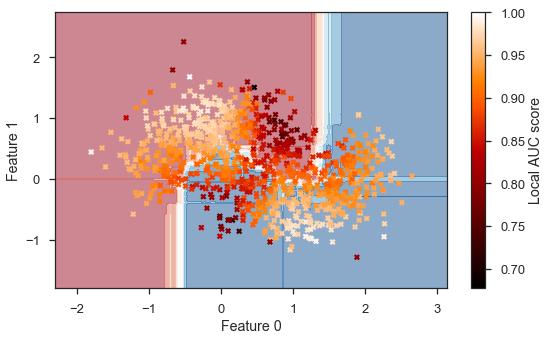

In [51]:
'''
plot de la heatmap
'''
sns.set_style('ticks')
sns.set_context("talk")


test_map = dataset.iloc[x_idxes].copy()
absents = dataset.iloc[list(set(range(dataset.shape[0])) - set(x_idxes))]
absents['lime'] = [0.8] * absents.shape[0]
test_map['LIME LocalAcc'] = np.array(lime_acc_list)
test_map.columns = ['Feature 0', 'Feature 1', 'lime'] 
absents.columns = ['Feature 0', 'Feature 1', 'lime'] 
test_map = test_map.append(absents)
print(test_map.shape)
print(test_map.tail())


fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,5))
ax = axs
plot_classification_contour(dataset, clf, ax)
# Plot training set
ylim_bak = ax.get_ylim()
#color_palette = sns.color_palette("bright", n_colors=len(lime_acc_list))

acc_gain_test = test_map['lime']

m = plt.cm.ScalarMappable(cmap='gist_heat')
m.set_array(acc_gain_test.tolist())#+ [0, 1]) #ajouter bornes pour centrer
plt.colorbar(m, label='Local AUC score')

test_map.plot(x=test_map.columns[0], y=test_map.columns[1], kind='scatter', 
              ax=ax, c=acc_gain_test, 
              cmap='gist_heat', marker='x', colorbar=None)

tight_layout()
savefig('./illustrations/whi_heatmap_lime.pdf')